In [1]:
import networkx as nx
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from peel_by_motif import *
import random, collections
from datetime import datetime
import pandas as pd
import itertools, os
from utils import *
import math
from networkx.drawing.nx_agraph import graphviz_layout
plt.rcParams.update({'font.size': 14})

In [2]:
import math
import numpy as np

def js_divergence(p, q):
    m = [(p[i] + q[i]) / 2 for i in range(len(p))]
    jsd = 0.5 * (sum(p[i] * math.log(p[i] / m[i], 2) for i in range(len(p)) if p[i] > 0) +
                  sum(q[i] * math.log(q[i] / m[i], 2) for i in range(len(q)) if q[i] > 0))
    return jsd

def node_chisquare(edgelist, node_num, dist, adjust_idx=1, directed='both', diff_func='chi'):
    node_induced_dist = [[] for i in range(node_num)]
    node_chis = []
    for edge in edgelist:
        if directed == 'both' or directed == 'out':
            if edge[0] < node_num:  # Check if the index is valid
                node_induced_dist[edge[0]].append(edge[2])
        if directed == 'both' or directed == 'in':
            if edge[1] < node_num:  # Check if the index is valid
                node_induced_dist[edge[1]].append(edge[2])

    for node_dist in node_induced_dist:
        count_dist = count_occ(node_dist, len(dist), adjust_idx)
        # Calculate the Jensen-Shannon Divergence (JSD) instead of KL divergence
        if diff_func == 'chi':
            node_chis.append(chisquare(count_dist, sum(count_dist) * np.array(dist))[0])
        elif diff_func == 'jsd':
            node_chis.append(js_divergence(np.array(count_dist) / sum(count_dist), np.array(dist)))
    return node_chis


In [3]:
benford = []
xs = [i for i in range(1,10)]
for i in range(9):
    benford.append(math.log10(1+1/(i+1)))

In [ ]:
import networkx as nx

# Function to get the start digit (assuming it's previously defined)
def get_start_digit(money):
    return int(str(money)[0])

# Create an empty directed graph
G = nx.DiGraph()

# Open the CSV file for reading
with open('source_file', 'r') as f:
    # Initialize variables
    edgelist = []
    node_map = {}
    # Skip the header
    f.readline()
    e_count = 0
    n_idx = 0

    for line in f:
        tmp = line.strip().split(',')
        date = tmp[-1]
        money = tmp[-2]

        if len(money) <= 4 or tmp[1] == tmp[2]:
            continue

        if tmp[1] not in node_map:
            node_map[tmp[1]] = n_idx
            n_idx += 1
        if tmp[2] not in node_map:
            node_map[tmp[2]] = n_idx
            n_idx += 1

        money = float(money[:3])
        edgelist.append((node_map[tmp[1]], node_map[tmp[2]], get_start_digit(money), money, date))

        if node_map[tmp[1]] in G and node_map[tmp[2]] in G[node_map[tmp[1]]]:
            G[node_map[tmp[1]]][node_map[tmp[2]]]['weight'] += money
        else:
            G.add_edge(node_map[tmp[1]], node_map[tmp[2]], weight=money)

        e_count += 1

# Write the edgelist to a file
with open('file_path', 'w') as f_out:
    for edge in edgelist:
        # Convert each edge to a string and write to the file
        f_out.write(','.join(map(str, edge)) + '\n')

print('Edgelist file has been created.')
print('Amount of transactions with >1 volume:', e_count, 'by', date)


Edgelist file has been created.
Amount of transactions with >1 volume: 5926150 by 2022/09/10 23:31


In [5]:
G.number_of_nodes(), G.number_of_edges()

(570453, 842128)

0.0003833156896651522


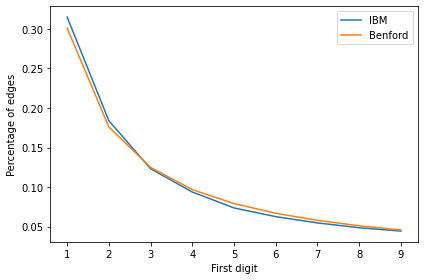

In [ ]:
x = [e[2] for e in edgelist]
x = collections.Counter(x)
num_occ = np.array([x[k] for k in range(1,10)])/sum([x[k] for k in range(1,10)])
print(js_divergence(num_occ,benford))
plt.plot([str(i) for i in range(1,10)], num_occ, label='IBM')
plt.plot([str(i) for i in range(1,10)], benford, label='Benford')
plt.xlabel('First digit')
plt.ylabel('Percentage of edges')
plt.legend()
plt.tight_layout()
plt.savefig('filepath')
plt.show()

In [7]:
obs = [x[k] for k in range(1,10)]
times = sum(obs)
c3,p3 = stats.chisquare(obs, np.array(benford)*times)
lr = -2 * sum([obs[i]*math.log(benford[i]/(obs[i]/times)) for i in range(9) if obs[i]!=0])
c3, c3/G.number_of_nodes(), c3/G.number_of_edges()

(12151.318985131318, 0.021301174654408547, 0.014429301703697441)

In [8]:
node_chisquares = node_chisquare(edgelist, G.number_of_nodes(), benford, adjust_idx=1, diff_func='jsd')

In [9]:
uG = G.to_undirected()
uG.remove_edges_from(nx.selfloop_edges(uG))
uG.number_of_nodes(), uG.number_of_edges()

(570453, 837346)

In [ ]:
from datetime import datetime
import math

edge_to_timestamp = {}
for e in edgelist:
    # Assuming e[0] is source, e[1] is target, and e[4] is the timestamp
    # We'll consider each edge as undirected for the purpose of matching, so we sort the tuple
    edge = tuple(sorted((e[0], e[1])))
    timestamp = e[4]
    # Update the timestamp for the edge if it's not already set or if this timestamp is more recent
    if edge not in edge_to_timestamp or datetime.strptime(timestamp, "%Y/%m/%d %H:%M") > datetime.strptime(edge_to_timestamp[edge], "%Y/%m/%d %H:%M"):
        edge_to_timestamp[edge] = timestamp

f_out = open('filepath', 'w')

for edge in uG.edges():
    # We'll again consider the edge as undirected for matching the timestamp
    edge_sorted = tuple(sorted(edge))
    weight = int(100 * math.sqrt(node_chisquares[edge[0]] * node_chisquares[edge[1]]))
    # Fetch the timestamp for the edge, using "Unknown" if not found
    timestamp = edge_to_timestamp.get(edge_sorted, "Unknown")
    # Write out the edge, weight, and timestamp
    f_out.write(f"{edge[0]} {edge[1]} {weight} {timestamp}\n")

f_out.close()


In [ ]:
import networkx as nx
import community  # Louvain community detection
from collections import defaultdict
import os


file_path = ''
G = nx.Graph()

with open(file_path, 'r') as file:
    for line in file:
        parts = line.strip().split()
        # Assuming the format is "source target weight timestamp"
        source, target, weight = map(int, parts[:3])  # Parses source, target, and weight, ignoring timestamp
        G.add_edge(source, target, weight=weight)

# Steps 2 to 5 remain the same

partition = community.best_partition(G)

community_data = defaultdict(lambda: {'nodes': set(), 'total_score': 0, 'frequency': 0})
for node, comm_id in partition.items():
    comm_id += 1  # Adjust community IDs to start from 1
    community_data[comm_id]['nodes'].add(node)
    community_data[comm_id]['frequency'] += 1
    for neighbor in G.neighbors(node):
        if partition[neighbor] == comm_id - 1:
            community_data[comm_id]['total_score'] += G[node][neighbor]['weight']

top_five_communities = []
for _ in range(5):
    most_anomalous_community = None
    for comm_id, data in community_data.items():
        if most_anomalous_community is None or (data['frequency'], data['total_score']) > (most_anomalous_community[1]['frequency'], most_anomalous_community[1]['total_score']):
            most_anomalous_community = (comm_id, data)
    if most_anomalous_community:
        top_five_communities.append(most_anomalous_community)
        del community_data[most_anomalous_community[0]]

output_directory = 'top_five_communities/'
os.makedirs(output_directory, exist_ok=True)

for i, (comm_id, data) in enumerate(top_five_communities):
    new_file_path = f'{output_directory}most_anomalous_community_{i+1}.txt'
    with open(new_file_path, 'w') as new_file:
        for node in data['nodes']:
            new_file.write(f'{node}\n')

    print(f'Most anomalous community {i+1} ID: {comm_id}')
    print(f'Number of nodes in the community: {len(data["nodes"])}')
    print(f'Total anomaly score in the community: {data["total_score"]}')


Most anomalous community 1 ID: 66
Number of nodes in the community: 31351
Total anomaly score in the community: 2577490
Most anomalous community 2 ID: 123
Number of nodes in the community: 22744
Total anomaly score in the community: 1889988
Most anomalous community 3 ID: 31
Number of nodes in the community: 19725
Total anomaly score in the community: 1413538
Most anomalous community 4 ID: 9
Number of nodes in the community: 19352
Total anomaly score in the community: 3487756
Most anomalous community 5 ID: 50
Number of nodes in the community: 18541
Total anomaly score in the community: 1567338


In [ ]:
import networkx as nx
import os
from statistics import median

output_directory = 'community_subgraphs/'
os.makedirs(output_directory, exist_ok=True)

# Iterate through the top five communities
for i, (comm_id, data) in enumerate(top_five_communities):
    community_nodes = data['nodes']

    # Create a subgraph for the current community
    community_subgraph = G.subgraph(community_nodes)

    # Calculate the median degree of nodes in this community
    degrees = [degree for node, degree in community_subgraph.degree()]
    median_degree = median(degrees)  # Dynamic threshold based on the community

    # Filter nodes based on the median degree
    filtered_nodes = [node for node, degree in community_subgraph.degree() if degree >= median_degree]

    # Write the filtered nodes to a file within the community's directory
    community_output_directory = os.path.join(output_directory, f'community_{comm_id}/')
    os.makedirs(community_output_directory, exist_ok=True)
    filtered_nodes_file_path = os.path.join(community_output_directory, 'filtered_nodes.txt')
    with open(filtered_nodes_file_path, 'w') as f:
        for node in filtered_nodes:
            f.write(f"{node}\n")

    print(f'Community {comm_id}: {len(filtered_nodes)} nodes with degree >= median degree')
    print(f'Median degree threshold: {median_degree}')
    print(f'Saved to: {filtered_nodes_file_path}')


Community 66: 21852 nodes with degree >= median degree
Median degree threshold: 2
Saved to: community_subgraphs/community_66/filtered_nodes.txt
Community 123: 16098 nodes with degree >= median degree
Median degree threshold: 2.0
Saved to: community_subgraphs/community_123/filtered_nodes.txt
Community 31: 12352 nodes with degree >= median degree
Median degree threshold: 2
Saved to: community_subgraphs/community_31/filtered_nodes.txt
Community 9: 14586 nodes with degree >= median degree
Median degree threshold: 2.0
Saved to: community_subgraphs/community_9/filtered_nodes.txt
Community 50: 12810 nodes with degree >= median degree
Median degree threshold: 2
Saved to: community_subgraphs/community_50/filtered_nodes.txt


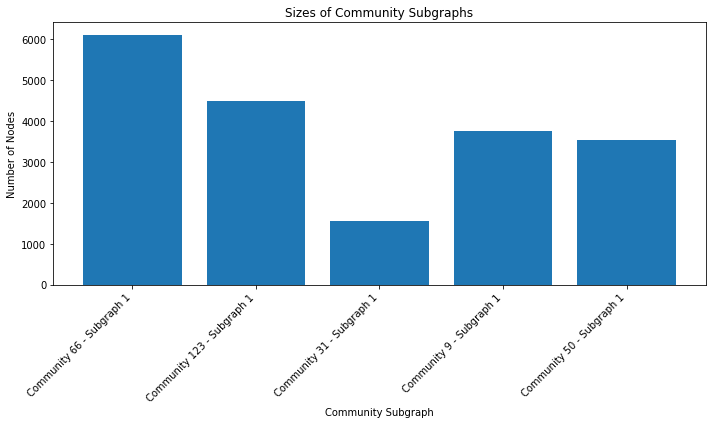

In [13]:
import matplotlib.pyplot as plt
from collections import Counter


# Initialize lists to store data for visualization
community_names = []
community_sizes = []

# Iterate through the top five communities and their subgraphs
for i, (comm_id, data) in enumerate(top_five_communities):
    # Extract the community subgraph datac
    community_nodes = data['nodes']
    community_subgraph = G.subgraph(community_nodes)
    connected_components = list(nx.connected_components(community_subgraph))

    # Process and collect data
    for j, component in enumerate(connected_components):
        subgraph = community_subgraph.subgraph(component)
        node_occurrences = Counter(node for edge in subgraph.edges for node in edge)
        min_occurrence = 5
        filtered_nodes = [node for node in subgraph.nodes if node_occurrences[node] >= min_occurrence]

        # Append data for visualization
        community_names.append(f'Community {comm_id} - Subgraph {j+1}')
        community_sizes.append(len(filtered_nodes))

# Create a bar chart to visualize the sizes of community subgraphs
plt.figure(figsize=(10, 6))
plt.bar(community_names, community_sizes)
plt.xticks(rotation=45, ha="right")
plt.xlabel('Community Subgraph')
plt.ylabel('Number of Nodes')
plt.title('Sizes of Community Subgraphs')
plt.tight_layout()
plt.show()


In [ ]:
import networkx as nx
import os
import plotly.graph_objects as go
import numpy as np

# Directory to store the subgraphs and high-degree nodes for each community
output_directory = 'community_subgraphs/'
os.makedirs(output_directory, exist_ok=True)

# Iterate through the top five communities
for i, (comm_id, data) in enumerate(top_five_communities):
    community_nodes = data['nodes']

    # Create a subgraph for the current community
    community_subgraph = G.subgraph(community_nodes).copy()

    # Calculate the degree for each node in the community
    degrees = dict(community_subgraph.degree())
    all_degrees = list(degrees.values())

    # Calculate the 90th percentile of the degree distribution to set as threshold
    degree_threshold = np.percentile(all_degrees, 90)

    # Identify nodes with degrees above the threshold
    high_degree_nodes = [node for node, degree in degrees.items() if degree >= degree_threshold]
    low_degree_nodes = [node for node, degree in degrees.items() if degree < degree_threshold]

     # Calculate statistics
    total_nodes = len(community_nodes)
    num_high_degree_nodes = len(high_degree_nodes)
    num_low_degree_nodes = len(low_degree_nodes)
    percent_high_degree_nodes = (num_high_degree_nodes / total_nodes) * 100
    percent_low_degree_nodes = (num_low_degree_nodes / total_nodes) * 100
    avg_degree_high = np.mean([degrees[node] for node in high_degree_nodes]) if high_degree_nodes else 0
    avg_degree_low = np.mean([degrees[node] for node in low_degree_nodes]) if low_degree_nodes else 0

    # Print statistics for each community
    print(f"Statistics for Community {comm_id}:")
    print(f"Total nodes: {total_nodes}")
    print(f"High-degree nodes: {num_high_degree_nodes} ({percent_high_degree_nodes:.2f}%)")
    print(f"Low-degree nodes: {num_low_degree_nodes} ({percent_low_degree_nodes:.2f}%)")
    print(f"Average degree of high-degree nodes: {avg_degree_high:.2f}")
    print(f"Average degree of low-degree nodes: {avg_degree_low:.2f}")
    print("-----------------------------------")

    # Create the dense subgraph
    dense_subgraph = community_subgraph.subgraph(high_degree_nodes)

    # Create an adjacency matrix for the dense subgraph using NumPy
    adjacency_matrix = nx.to_numpy_array(dense_subgraph)

    pos = nx.spring_layout(dense_subgraph)

    edge_x = []
    edge_y = []
    for edge in dense_subgraph.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    for node in dense_subgraph.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            size=10,
            color=[],
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))

    node_adjacencies = []
    node_text = []
    for node, adjacencies in enumerate(dense_subgraph.adjacency()):
        node_adjacencies.append(len(adjacencies[1]))
        node_text.append(f'# of connections: {len(adjacencies[1])}')

    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text

    fig = go.Figure(data=[edge_trace, node_trace],
                 layout=go.Layout(
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0, l=0, r=0, t=0),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

    # Adjust the plot's file name for each community
    plot_file_name = os.path.join(output_directory, f'community_{comm_id}_dense_subgraph.html')
    fig.write_html(plot_file_name)
    print(f'Dense subgraph visualization saved as {plot_file_name}')

Statistics for Community 66:
Total nodes: 31351
High-degree nodes: 4040 (12.89%)
Low-degree nodes: 27311 (87.11%)
Average degree of high-degree nodes: 9.31
Average degree of low-degree nodes: 2.32
-----------------------------------
Dense subgraph visualization saved as community_subgraphs/community_66_dense_subgraph.html
Statistics for Community 123:
Total nodes: 22744
High-degree nodes: 3068 (13.49%)
Low-degree nodes: 19676 (86.51%)
Average degree of high-degree nodes: 9.38
Average degree of low-degree nodes: 2.33
-----------------------------------
Dense subgraph visualization saved as community_subgraphs/community_123_dense_subgraph.html
Statistics for Community 31:
Total nodes: 19725
High-degree nodes: 3219 (16.32%)
Low-degree nodes: 16506 (83.68%)
Average degree of high-degree nodes: 5.29
Average degree of low-degree nodes: 1.76
-----------------------------------
Dense subgraph visualization saved as community_subgraphs/community_31_dense_subgraph.html
Statistics for Community 9

In [15]:
# Assuming edge_to_timestamp and top_five_communities are defined as in your setup
from datetime import datetime
import matplotlib.pyplot as plt

# Initialize a dictionary to hold the first and last timestamps for each community
community_time_span = {}

for comm_id, data in top_five_communities:
    timestamps = []
    for node in data['nodes']:
        for neighbor in G.neighbors(node):
            if neighbor in data['nodes']:
                edge = (node, neighbor)
                # Check both edge directions since the graph might be undirected
                timestamp = edge_to_timestamp.get(edge) or edge_to_timestamp.get((neighbor, node))
                if timestamp:
                    timestamps.append(datetime.strptime(timestamp, "%Y/%m/%d %H:%M"))
    
    if timestamps:
        community_time_span[comm_id] = (min(timestamps), max(timestamps))

# Output the time span of each community
for comm_id, (start_time, end_time) in community_time_span.items():
    print(f"Community {comm_id} spans from {start_time} to {end_time}")


Community 66 spans from 2022-09-01 00:00:00 to 2022-09-14 13:48:00
Community 123 spans from 2022-09-01 00:00:00 to 2022-09-14 14:10:00
Community 31 spans from 2022-09-01 00:00:00 to 2022-09-11 13:28:00
Community 9 spans from 2022-09-01 00:00:00 to 2022-09-10 23:59:00
Community 50 spans from 2022-09-01 00:00:00 to 2022-09-10 23:59:00


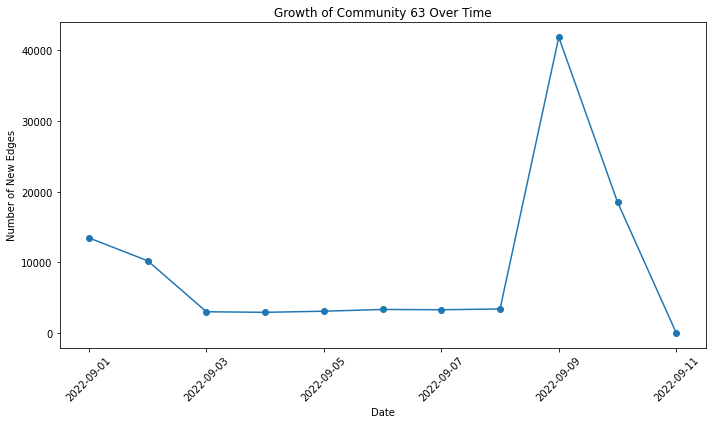

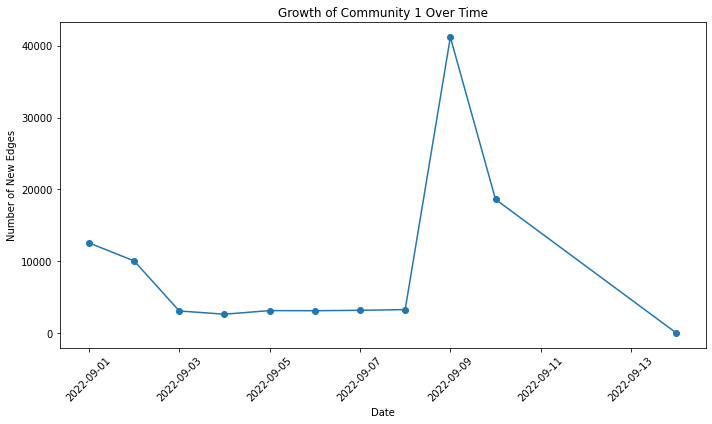

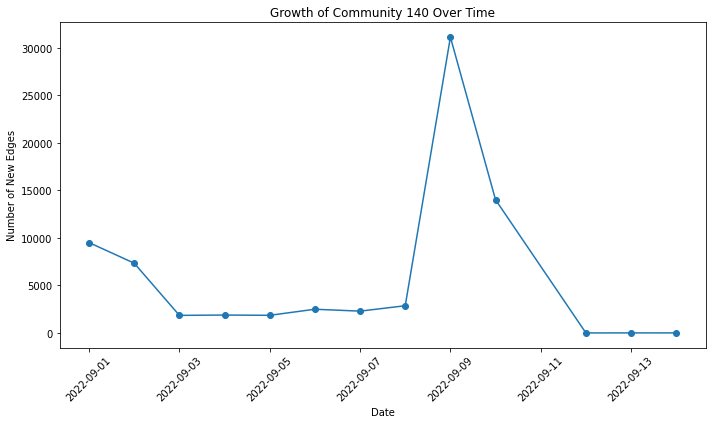

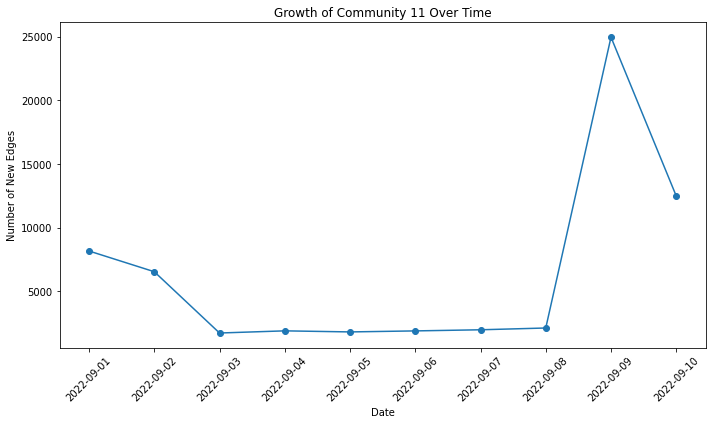

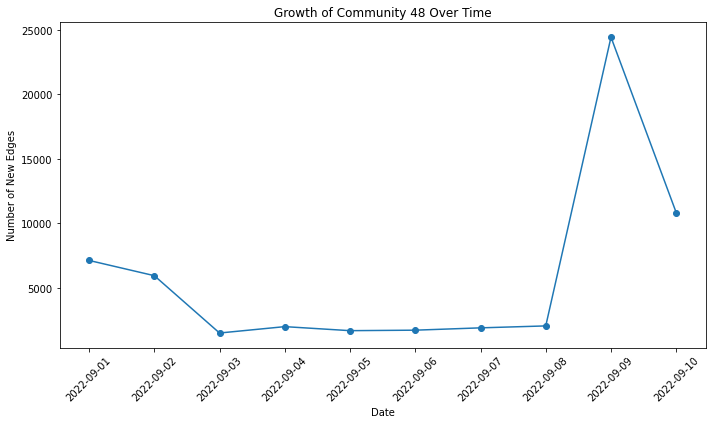

In [16]:
import matplotlib.pyplot as plt
from datetime import datetime

def plot_community_growth(community_nodes, edge_to_timestamp, comm_id):
    time_edges = []

    for node in community_nodes:
        for neighbor in G.neighbors(node):
            if neighbor in community_nodes:
                timestamp = edge_to_timestamp.get((node, neighbor)) or edge_to_timestamp.get((neighbor, node))
                if timestamp:
                    time_edges.append(datetime.strptime(timestamp, "%Y/%m/%d %H:%M"))

    # Counting edges per day
    edges_per_day = {}
    for time in time_edges:
        day = time.date()
        edges_per_day[day] = edges_per_day.get(day, 0) + 1

    # Sorting dates for plotting
    dates = sorted(edges_per_day.keys())
    counts = [edges_per_day[date] for date in dates]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(dates, counts, marker='o', linestyle='-')
    plt.title(f"Growth of Community {comm_id} Over Time")
    plt.xlabel("Date")
    plt.ylabel("Number of New Edges")
    plt.xticks(rotation=45)
    plt.tight_layout()

# Correctly calling the plot function for each community
for i, (comm_id, data) in enumerate(top_five_communities):
    plot_community_growth(data['nodes'], edge_to_timestamp, comm_id)
    plt.show()  # Ensure plt.show() is called once after each plot setup
